In [ ]:
import pandas as pd
import re

df = pd.read_csv("../data/bot_detection_data.csv")

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"\s+", " ", text).strip()
    return text

final_df = pd.DataFrame({
    "Text": df["Tweet"].map(clean_text),
    "Bot Label": df["Bot Label"]
})

# remove empty rows
final_df = final_df[final_df["Text"].str.len() > 0]

# remove duplicates
final_df = final_df.drop_duplicates(subset=["Text"]).reset_index(drop=True)

print(final_df.shape)
final_df.head(10000)

(50000, 2)


,Text,Bot Label
0,Station activity person against natural majori...,1
1,Authority research natural life material staff...,0
2,Manage whose quickly especially foot none to g...,0
3,Just cover eight opportunity strong policy which.,1
4,Animal sign six data good or.,1
...,...,...
9995,Describe provide him message important account...,0
9996,Area force identify grow hot situation list ex...,1
9997,Rock everybody painting a kind unit set wind Mr.,1
9998,Matter claim across southern relate need.,1


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [11]:
# Create TF-IDF features from the preprocessed text
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', min_df=2)

# Prepare text and labels
X_text = final_df["Text"].astype(str).tolist()
y_labels = final_df["Bot Label"].to_numpy()

# Split into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

# Create TF-IDF vectors
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

print(f"Training set: {len(X_train_text)} samples")
print(f"Test set: {len(X_test_text)} samples")
print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"Each document is represented as a single vector of {X_train_tfidf.shape[1]} dimensions")

Creating TF-IDF features...
Training set: 40000 samples
Test set: 10000 samples
TF-IDF feature shape: (40000, 763)
Each document is represented as a single vector of 763 dimensions


In [12]:
# Train Logistic Regression model with TF-IDF features
print("=" * 60)
print("TRAINING: Logistic Regression with TF-IDF features")
print("=" * 60)

# Create and train the model
tfidf_model = LogisticRegression(max_iter=1000, random_state=42)
tfidf_model.fit(X_train_tfidf, y_train)

print("Model trained successfully!")

TRAINING: Logistic Regression with TF-IDF features
Model trained successfully!


In [13]:
# Evaluate the model and print classification report
target_names = ['Human', 'Bot']   

print("=" * 60)
print("CLASSIFICATION REPORT: Logistic Regression (TF-IDF)")
print("=" * 60)

# Make predictions
y_pred = tfidf_model.predict(X_test_tfidf)

# Print results
print(classification_report(y_test, y_pred, target_names=target_names))
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion matrix
print("\n" + "=" * 60)
print("CONFUSION MATRIX:")
print("=" * 60)
print(confusion_matrix(y_test, y_pred))

CLASSIFICATION REPORT: Logistic Regression (TF-IDF)
              precision    recall  f1-score   support

       Human       0.50      0.50      0.50      4996
         Bot       0.50      0.50      0.50      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000


Test Accuracy: 0.5009

CONFUSION MATRIX:
[[2507 2489]
 [2502 2502]]


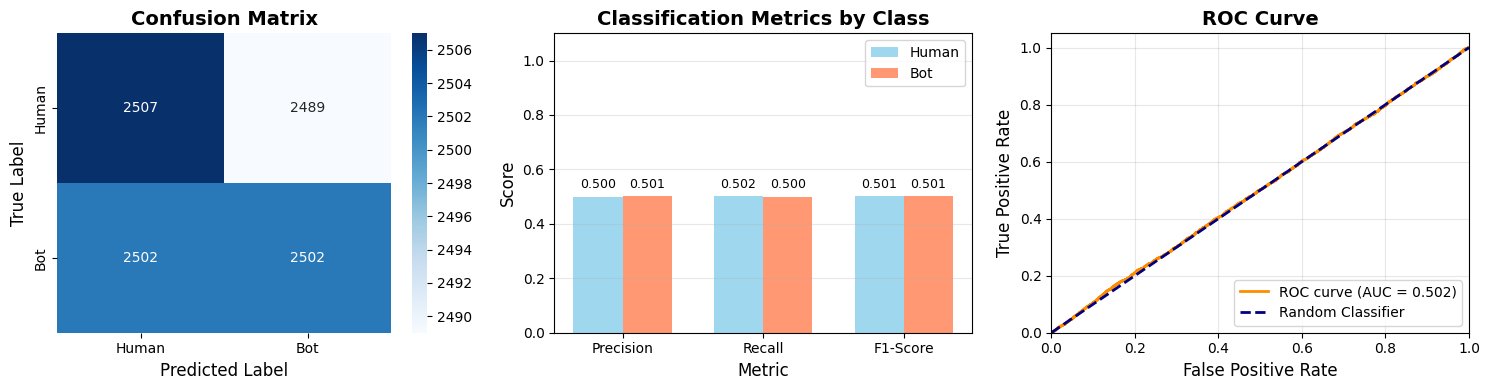


SUMMARY STATISTICS
Overall Accuracy: 0.5009
ROC AUC Score: 0.5021

Human - Precision: 0.5005, Recall: 0.5018, F1: 0.5011
Bot   - Precision: 0.5013, Recall: 0.5000, F1: 0.5007


In [14]:
# Visualize the results
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics for plotting
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
metrics = {
    'Human': [precision[0], recall[0], f1[0]],
    'Bot': [precision[1], recall[1], f1[1]]
}

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# 2. Metrics Comparison Bar Chart
x = np.arange(len(['Precision', 'Recall', 'F1-Score']))
width = 0.35
axes[1].bar(x - width/2, metrics['Human'], width, label='Human', alpha=0.8, color='skyblue')
axes[1].bar(x + width/2, metrics['Bot'], width, label='Bot', alpha=0.8, color='coral')
axes[1].set_xlabel('Metric', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (h_val, b_val) in enumerate(zip(metrics['Human'], metrics['Bot'])):
    axes[1].text(i - width/2, h_val + 0.02, f'{h_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, b_val + 0.02, f'{b_val:.3f}', ha='center', va='bottom', fontsize=9)

# 3. ROC Curve
y_pred_proba = tfidf_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontsize=12)
axes[2].set_ylabel('True Positive Rate', fontsize=12)
axes[2].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[2].legend(loc="lower right")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"\nHuman - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Bot   - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

In [159]:
import torch.nn as nn
import torch.nn.functional as F

class FF_Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # Layers (input dim will depend on data preprocessing!)
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Pass through layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = self.fc4(x)

        return x

In [160]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [161]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to tensors
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [162]:
input_dim = X_train_tfidf.shape[1]

model = FF_Net(input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

In [163]:
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.6933
Epoch 2/20, Loss: 0.6932
Epoch 3/20, Loss: 0.6931
Epoch 4/20, Loss: 0.6926
Epoch 5/20, Loss: 0.6908
Epoch 6/20, Loss: 0.6883
Epoch 7/20, Loss: 0.6861
Epoch 8/20, Loss: 0.6841
Epoch 9/20, Loss: 0.6806
Epoch 10/20, Loss: 0.6742
Epoch 11/20, Loss: 0.6601
Epoch 12/20, Loss: 0.6295
Epoch 13/20, Loss: 0.5783
Epoch 14/20, Loss: 0.5181
Epoch 15/20, Loss: 0.4676
Epoch 16/20, Loss: 0.4149
Epoch 17/20, Loss: 0.3847
Epoch 18/20, Loss: 0.3479
Epoch 19/20, Loss: 0.3243
Epoch 20/20, Loss: 0.3014


In [164]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    probs = torch.sigmoid(outputs)
    preds = (probs >= 0.5).int().cpu()

y_pred_nn = preds.numpy()

CLASSIFICATION REPORT: Neural Network (TF-IDF)
              precision    recall  f1-score   support

       Human       0.50      0.46      0.48      4996
         Bot       0.50      0.55      0.52      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000


Test Accuracy: 0.5035
CONFUSION MATRIX:
[[2304 2692]
 [2273 2731]]


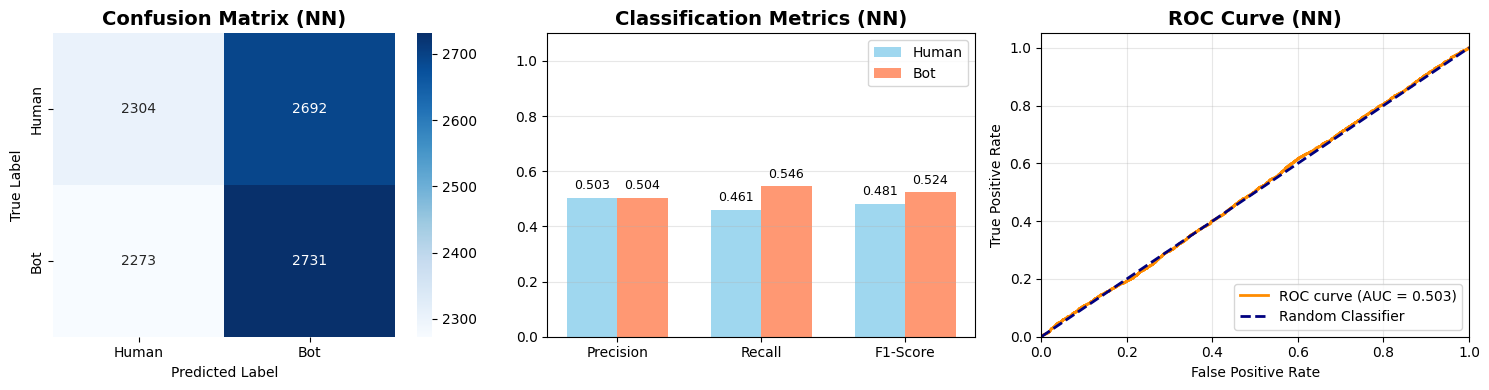

SUMMARY STATISTICS (Neural Network)
Overall Accuracy: 0.5035
ROC AUC Score: 0.5030

Human - Precision: 0.5034, Recall: 0.4612, F1: 0.4814
Bot   - Precision: 0.5036, Recall: 0.5458, F1: 0.5238


In [165]:
# Convert tensors to numpy
y_pred_nn = preds.numpy().flatten()
y_pred_proba_nn = probs.cpu().numpy().flatten()

print("CLASSIFICATION REPORT: Neural Network (TF-IDF)")

target_names = ['Human', 'Bot']

print(classification_report(y_test, y_pred_nn, target_names=target_names))
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")

print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_nn))

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nn, average=None
)

metrics = {
    'Human': [precision[0], recall[0], f1[0]],
    'Bot': [precision[1], recall[1], f1[1]]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Human', 'Bot'],
            yticklabels=['Human', 'Bot'])
axes[0].set_title('Confusion Matrix (NN)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


# 2. Precision / Recall / F1
x = np.arange(len(['Precision', 'Recall', 'F1-Score']))
width = 0.35

axes[1].bar(x - width/2, metrics['Human'], width,
            label='Human', alpha=0.8, color='skyblue')
axes[1].bar(x + width/2, metrics['Bot'], width,
            label='Bot', alpha=0.8, color='coral')

axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
axes[1].set_ylim([0, 1.1])
axes[1].set_title('Classification Metrics (NN)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (h_val, b_val) in enumerate(zip(metrics['Human'], metrics['Bot'])):
    axes[1].text(i - width/2, h_val + 0.02, f'{h_val:.3f}',
                 ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, b_val + 0.02, f'{b_val:.3f}',
                 ha='center', va='bottom', fontsize=9)


# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_nn)
roc_auc = auc(fpr, tpr)

axes[2].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2,
             linestyle='--', label='Random Classifier')

axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_title('ROC Curve (NN)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend(loc="lower right")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("SUMMARY STATISTICS (Neural Network)")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"\nHuman - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Bot   - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")